## Models Training and saving

- This notebook contains the model training using the train_pipeline module of utils. 
- It saves all the trained model in pkl formet and their evaluation matrices.

#### importing train_pipeline and model_saver packages

In [13]:
import sys
sys.path.append('..')

from src.utils.train_pipeline import train_pipeline
from src.utils.model_saver import save_model
from src.utils.visualizer import plot_roc_curve, plot_confusion_matrix
from src.utils.evaluater import evaluate_model

In [2]:
# path of preprocessed data
data_path = "E:\\Hospital_Readmission_Prediction\\data\\processed\\preprocessed_data.csv"

## 1. Logistic Regeression

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

In [5]:
# Training logistic regression model
lr_pipeline, lr_results, (y_test, y_pred, y_proba) = train_pipeline(data_path, model)
lr_pipeline

{'Model': 'LogisticRegression', 'F1 Score': 0.2525700463616206, 'ROC-AUC': np.float64(0.6408941992723493), 'Precision': 0.8341150571324965, 'Recall': 0.6356490124791195, 'Accuracy': 0.6356490124791195, 'Confusion Matrix': [[11685, 6384], [1032, 1253]]}


Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=1000))])

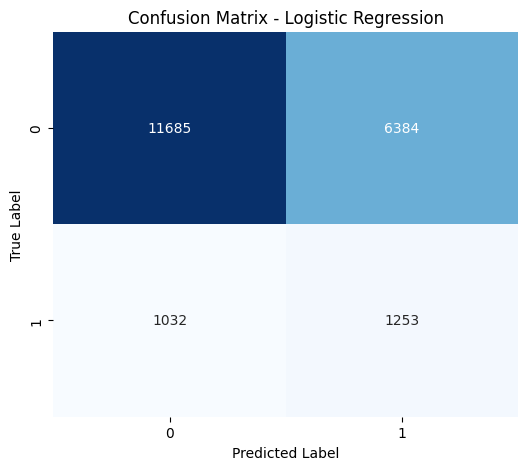

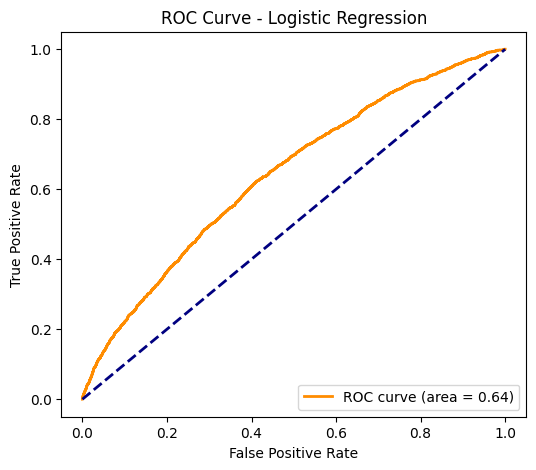

In [6]:
plot_confusion_matrix(y_test, y_pred, model_name="Logistic Regression")

if y_proba is not None:
    plot_roc_curve(y_test, y_proba, model_name="Logistic Regression")

In [7]:
# saving the model
save_model(lr_pipeline, 'logistic_regression_model.pkl')

Model saved to E:\Hospital_Readmission_Prediction\models\logistic_regression_model.pkl


## 2. Decision tree

In [8]:
from sklearn.tree import DecisionTreeClassifier
# using decision tree model at default parameters
model = DecisionTreeClassifier()

In [9]:
dt_pipeline, dt_results, (y_test, y_pred, y_proba) = train_pipeline(data_path, model, model_type='tree')
dt_pipeline

{'Model': 'DecisionTreeClassifier', 'F1 Score': 0.16793595000976372, 'ROC-AUC': np.float64(0.527513786502579), 'Precision': 0.8107551483472971, 'Recall': 0.7906553994300874, 'Accuracy': 0.7906553994300874, 'Confusion Matrix': [[15663, 2406], [1855, 430]]}


Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('model', DecisionTreeClassifier())])

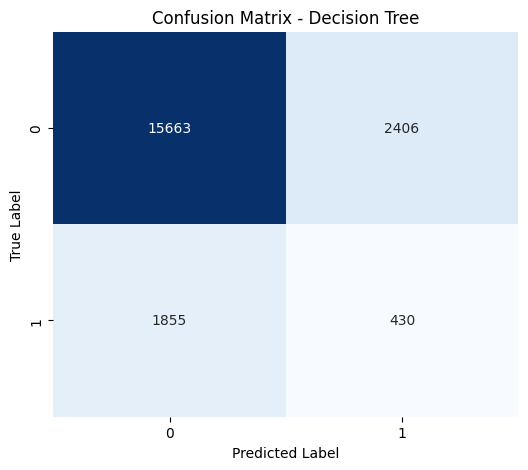

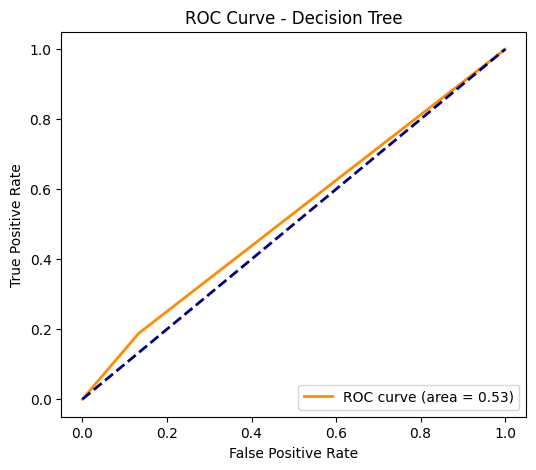

In [10]:
plot_confusion_matrix(y_test, y_pred, model_name="Decision Tree")

if y_proba is not None:
    plot_roc_curve(y_test, y_proba, model_name="Decision Tree")

In [11]:
# saving the model
save_model(dt_pipeline, 'decision_tree_model.pkl')

Model saved to E:\Hospital_Readmission_Prediction\models\decision_tree_model.pkl


- Tree is overfitting or not properly handling imbalance (since recall is high but precision/F1 are poor for minority class)

- fine tuning the model using gridsearch cv

## 3. Random Forest classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
# using random forest model 
rf_model = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=None,          # Let trees grow fully
    min_samples_split=2,     # Minimum samples required to split a node
    min_samples_leaf=1,      # Minimum samples at a leaf node
    max_features='sqrt',     # Number of features to consider at each split
    bootstrap=True,          # Use bootstrap samples
    random_state=42,
    n_jobs=-1                # Use all available CPU cores
)

In [14]:
rf_pipeline, rf_results, (y_test, y_pred, y_proba) = train_pipeline(data_path, rf_model, model_type='tree')
rf_pipeline

{'Model': 'RandomForestClassifier', 'F1 Score': 0.032939189189189186, 'ROC-AUC': np.float64(0.6444700009070505), 'Precision': 0.8421270211045683, 'Recall': 0.8874914021813894, 'Accuracy': 0.8874914021813894, 'Confusion Matrix': [[18025, 44], [2246, 39]]}


Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('model',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

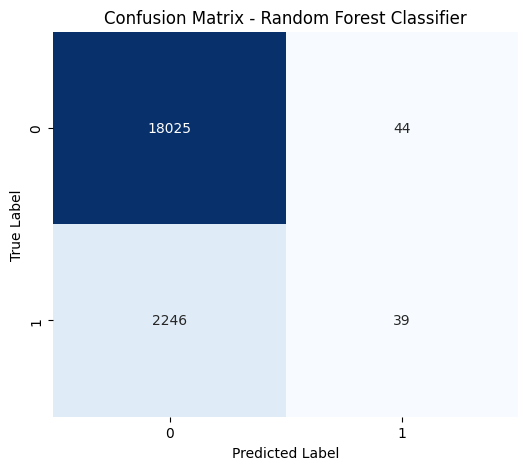

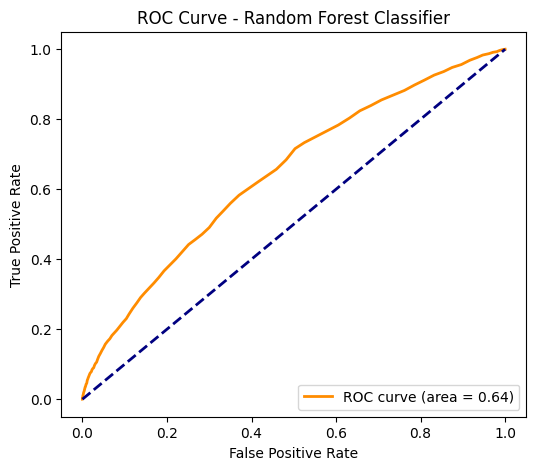

In [15]:
plot_confusion_matrix(y_test, y_pred, model_name="Random Forest Classifier")

if y_proba is not None:
    plot_roc_curve(y_test, y_proba, model_name="Random Forest Classifier")

In [17]:
# saving the random forest model
save_model(rf_pipeline, "random_forest_model.pkl")

Model saved to E:\Hospital_Readmission_Prediction\models\random_forest_model.pkl


- Only 39 true positives for class 1 out of 2,285 → extremely poor minority class prediction.
- Very low F1 Score (~0.033): The F1 score is extremely low, which means the model is failing to correctly identify the minority class (1 = readmitted).
- High precision and recall for the majority class: Precision and recall values are dominated by the majority class (0), showing the model is biased.

#### hyperparameter tuning of random forest classifier

In [19]:
# hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',           # Focus on F1 for minority class
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [10]:
# Individually loading data and spliting into train and test sets
from src.utils.data_loader import train_test_split_data, split_X_y, load_data
df = load_data(data_path)
X, y = split_X_y(df)
X_train, X_test, y_train, y_test = train_test_split_data(X, y, test_size=0.2, random_state=42)

In [26]:
# fitting the grid search pipeline
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='f1', verbose=2)

In [27]:
# Best params and model
print("Best parameters found:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best parameters found: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# model evaluation
from src.utils.evaluater import evaluate_model
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

results = evaluate_model(y_test, y_pred, y_proba, model_name="Tuned Random Forest")
print(results)

{'Model': 'Tuned Random Forest', 'F1 Score': 0.2763235121493133, 'ROC-AUC': np.float64(0.6742441114071237), 'Precision': 0.8392717199159987, 'Recall': 0.6971111329468409, 'Accuracy': 0.6971111329468409, 'Confusion Matrix': [[13012, 5057], [1108, 1177]]}


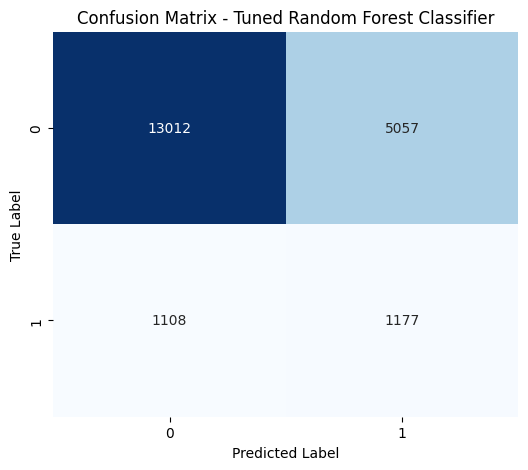

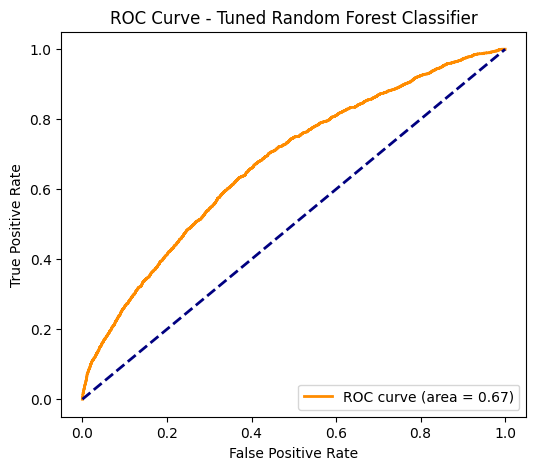

In [ ]:
# Plots
plot_confusion_matrix(y_test, y_pred, model_name="Tuned Random Forest Classifier")

if y_proba is not None:
    plot_roc_curve(y_test, y_proba, model_name="Tuned Random Forest Classifier")

In [ ]:
# saving model
save_model(best_rf,"tuned_random_forest_model.pkl")

Model saved to E:\Hospital_Readmission_Prediction\models\tuned_random_forest_model.pkl


### 4. XGBoost

In [3]:
from xgboost import XGBClassifier
# using XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

In [4]:
# Training XGBoost model
xgb_pipeline, xgb_results, (y_test, y_pred, y_proba) = train_pipeline(data_path, xgb_model, model_type='tree')
xgb_pipeline

c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:49:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Model': 'XGBClassifier', 'F1 Score': 0.030612244897959183, 'ROC-AUC': np.float64(0.6701146698414647), 'Precision': 0.8496436491638386, 'Recall': 0.8879827061019947, 'Accuracy': 0.8879827061019947, 'Confusion Matrix': [[18038, 31], [2249, 36]]}


Pipeline(steps=[('scaler', RobustScaler()), ('smote', SMOTE(random_state=42)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

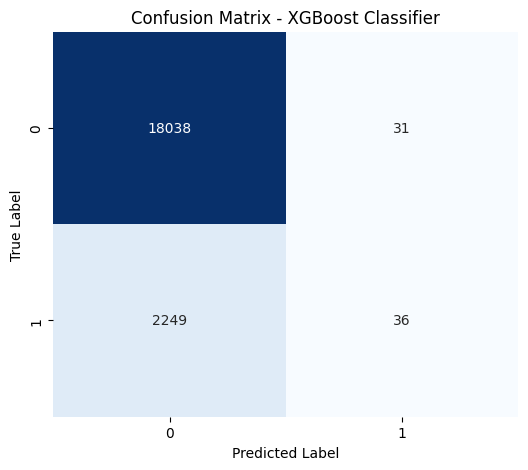

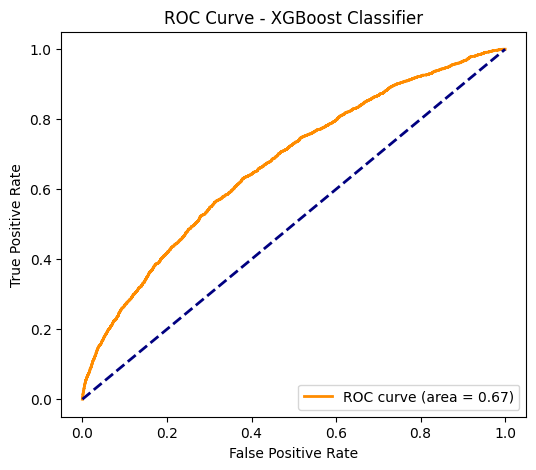

In [5]:
plot_confusion_matrix(y_test, y_pred, model_name="XGBoost Classifier")

if y_proba is not None:
    plot_roc_curve(y_test, y_proba, model_name="XGBoost Classifier")

In [6]:
# saving the model
save_model(xgb_pipeline, 'xgboost_model.pkl')

Model saved to E:\Hospital_Readmission_Prediction\models\xgboost_model.pkl


- Since the f1score is too low, hypertuning the parameters

In [8]:
param_grid = {
    'n_estimators': [100, 200, 300],          # number of trees
    'max_depth': [3, 5, 7, 9],                # maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # step size shrinkage
    'subsample': [0.6, 0.8, 1.0],             # fraction of samples used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],      # fraction of features used per tree
    'gamma': [0, 1, 5],                       # minimum loss reduction required to make a further partition
    'min_child_weight': [1, 3, 5]             # minimum sum of instance weight (hessian)
}

xgb_model = XGBClassifier(
    eval_metric='logloss',  
    random_state=42,
    use_label_encoder=False
)

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',           # to focus on F1 for minority class
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [11]:
# fitting the grid search pipeline
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:22:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='f1', verbose=2)

In [12]:
# Best parameter and model
print("Best parameters found for XGB:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

Best parameters found for XGB: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.6}


In [17]:
# Evaluate best model
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

xgb_tuned_results = evaluate_model(y_test, y_pred, y_proba, model_name="Tuned XGB Classifier")
print(xgb_tuned_results)

{'Model': 'Tuned XGB Classifier', 'F1 Score': 0.10695587135377711, 'ROC-AUC': np.float64(0.6318220708291448), 'Precision': 0.8337626376778964, 'Recall': 0.8826766237594575, 'Accuracy': 0.8826766237594575, 'Confusion Matrix': [[17823, 246], [2142, 143]]}


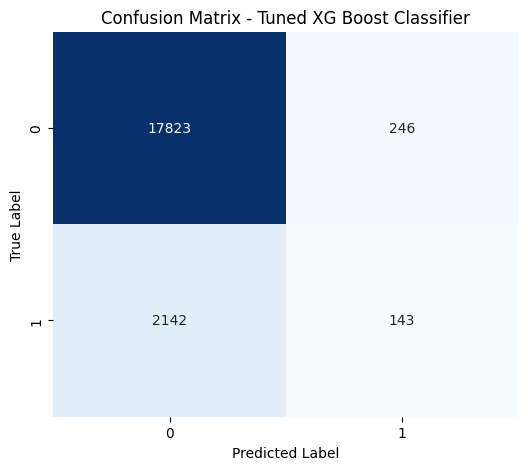

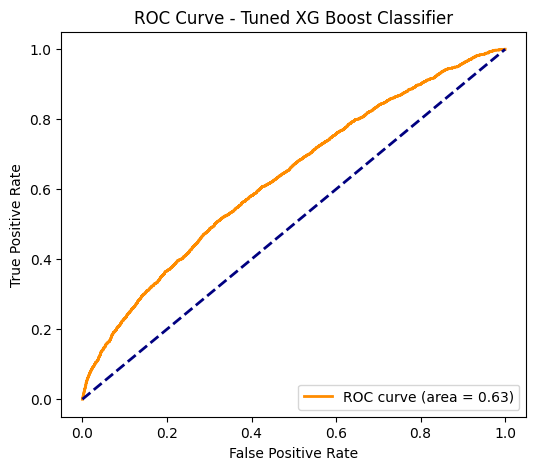

In [15]:
# Plots
plot_confusion_matrix(y_test, y_pred, model_name="Tuned XG Boost Classifier")

if y_proba is not None:
    plot_roc_curve(y_test, y_proba, model_name="Tuned XG Boost Classifier")

In [16]:
# saving best xgb model
save_model(best_xgb, "tuned_XGB_model.pkl")

Model saved to E:\Hospital_Readmission_Prediction\models\tuned_XGB_model.pkl


### Model comparisons

In [18]:
import pandas as pd
import numpy as np

In [ ]:
results = [
    lr_results,
    dt_results,
    rf_results,
    results, # from tuned random forest (forgot to name it differently)
    xgb_results,
    xgb_tuned_results
]

In [22]:
df_results = pd.DataFrame(results)

In [25]:
display(df_results)

,Model,F1 Score,ROC-AUC,Precision,Recall,Accuracy,Confusion Matrix
0,LogisticRegression,0.2526,0.6409,0.8341,0.6356,0.6356,"[[11685, 6384], [1032, 1253]]"
1,DecisionTreeClassifier,0.1679,0.5275,0.8108,0.7907,0.7907,"[[15663, 2406], [1855, 430]]"
2,RandomForestClassifier,0.0329,0.6445,0.8421,0.8875,0.8875,"[[18025, 44], [2246, 39]]"
3,Tuned Random Forest,0.2763,0.6742,0.8393,0.6971,0.6971,"[[13012, 5057], [1108, 1177]]"
4,XGBClassifier,0.0306,0.6701,0.8496,0.8880,0.8880,"[[18038, 31], [2249, 36]]"
5,Tuned XGB Classifier,0.1070,0.6318,0.8338,0.8827,0.8827,"[[17823, 246], [2142, 143]]"


- Best F1 Score:
    - Tuned Random Forest (0.2763) -> highest F1, meaning it balances precision & recall the best.

- Best ROC-AUC:
    - Tuned Random Forest (0.6742) -> indicates better overall separability between classes.

- High Accuracy != Best Model:
    - The untuned Random Forest and XGBoost models show high accuracy (~0.88),
        but that’s misleading -> they are predicting mostly the majority class (negative),
        which explains the low F1 Scores (~0.03).

- Tuned Random Forest vs Tuned XGBoost:
    - Both are tuned, but Random Forest tuning clearly improved both F1 and ROC-AUC significantly.
    - Tuned XGB’s performance actually degraded slightly in ROC-AUC.

### Best Model: Tuned Random Forest Classifier